# Exploration of berries prices in the spanish market

### Cleanance

In [1]:
import pyodbc
import pandas as pd
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
connStr = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=bipro02\\adminbi;DATABASE=Prices;Trusted_Connection=yes')
cursor = connStr.cursor()

qry = "SELECT * FROM [Prices].[dbo].[prices] where cast([Country] as nvarchar) = cast('ES' as nvarchar)"
df_prices = pd.read_sql(qry, connStr)

df_prices.shape

(445, 11)

In [2]:
df_prices.head()
df_prices['Campaign_Date'] = df_prices['Year_campaign'].astype(str) + df_prices['Week_num_campaign'].astype(str)
# https://stackoverflow.com/questions/17087314/get-date-from-week-number
df_prices['Campaign_Date'] = df_prices['Campaign_Date'].apply(lambda x: datetime.datetime.strptime(x + '-1', "%Y%W-%w"))
df_prices.head()

,Product,Price,Country,Currency,Measure,Date_ref,Week_desc,Week_num,Year_num,Week_num_campaign,Year_campaign,Campaign_Date
0,BLUEBERRIES,4.732598,ES,EUR,KG,2018-04-09,15-2018,15,2018,15,2018,2018-04-09
1,RASPBERRIES,4.640552,ES,EUR,KG,2015-12-28,53-2015,53,2015,18,2016,2016-05-02
2,RASPBERRIES,5.935458,ES,EUR,KG,2018-11-19,47-2018,47,2018,12,2019,2019-03-25
3,STRAWBERRIES,0.891319,ES,EUR,KG,2017-05-29,22-2017,22,2017,27,2017,2017-07-03
4,RASPBERRIES,6.286667,ES,EUR,KG,2018-11-26,48-2018,48,2018,13,2019,2019-04-01


In [3]:
blue = df_prices[(df_prices.Product=='BLUEBERRIES') & (df_prices.Year_campaign>2015) & (df_prices.Week_num_campaign<50)][['Campaign_Date', 'Price']]
blue.set_index('Campaign_Date',inplace=True)
blue.sort_index(inplace=True)

### Ploting

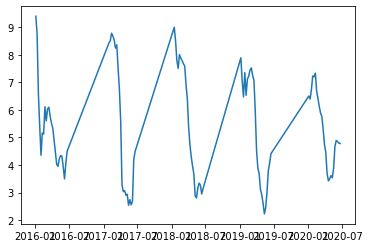

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.plot(blue)

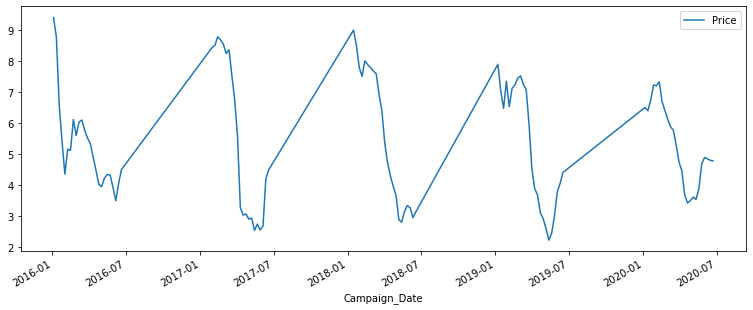

In [5]:
fig, ax = plt.subplots(figsize= (13,5))
blue.plot(ax=ax);

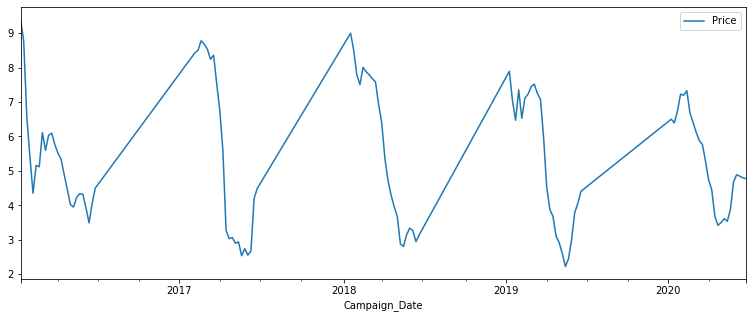

In [6]:
blue=blue.to_period('W')
fig, ax = plt.subplots(figsize= (13,5))
blue.plot(ax=ax);

In [7]:
for y in range(2017,2020):
    c = blue[blue.index.year==y]['Price'].reset_index()['Price'][0:21].corr(blue[blue.index.year==y+1].reset_index()['Price'][0:21])
    print(f'Correlations between campaigns {y} and {y+1}: {c}')

Correlations between campaigns 2017 and 2018: 0.8956249612699594
Correlations between campaigns 2018 and 2019: 0.9596971317866023
Correlations between campaigns 2019 and 2020: 0.9186404540673154


### ACF correlation function

In [8]:
from statsmodels.tsa.stattools import acf
acf(blue)

array([ 1.        ,  0.86099921,  0.69173673,  0.50769697,  0.3183467 ,
        0.14362857, -0.05023278, -0.23704666, -0.41540445, -0.56887328,
       -0.67815009, -0.73738619, -0.72095721, -0.63946176, -0.52961015,
       -0.39298038, -0.23239699, -0.05520099,  0.13565363,  0.30534631,
        0.42913097,  0.52142712,  0.56647676,  0.610923  ,  0.60311186,
        0.56430528,  0.46313799,  0.33730767,  0.20326501,  0.05632959,
       -0.0852541 , -0.21046385, -0.32860152, -0.42902487, -0.51421802,
       -0.54360395, -0.51022959, -0.44601947, -0.35997623, -0.25384561,
       -0.15235248])

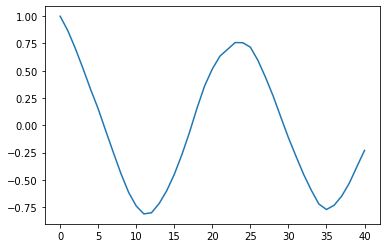

In [9]:
plt.plot(acf(blue,unbiased=True))

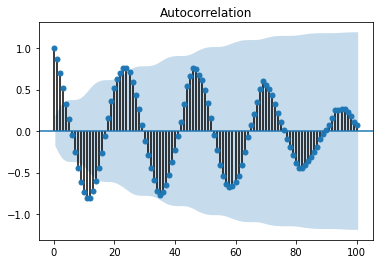

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(blue,lags=100,unbiased=True);

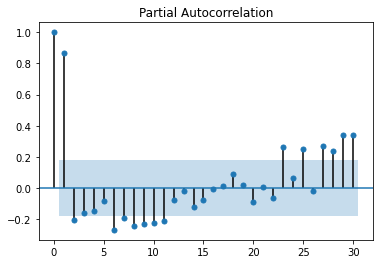

In [12]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(blue, lags = 30);

In [13]:
blue[1:2]

,Price
Campaign_Date,
2016-01-11/2016-01-17,8.77146


## First model!!
## https://www.youtube.com/watch?v=WjeGUs6mzXg

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(blue, order = (2,1,3)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  118
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -154.979
Date:                Sat, 04 Jul 2020   AIC                            321.958
Time:                        16:47:33   BIC                            338.531
Sample:                    01-10-2016   HQIC                           328.687
                         - 06-28-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5330      2.120     -0.251      0.801      -4.687       3.621
ar.L2         -0.0883      1.248     -0.071      0.944      -2.535       2.359
ma.L1          0.6642      2.123      0.313      0.754      -3.496       4.824
ma.L2          0.3050      1.141      0.267      0.789      -1.931       2.541
ma.L3          0.1447      0.235      0.616      0.538      -0.316       0.605
sigma2         0.8275      0.048     17.262      0.000       0.734       0.921
===================================================================================
Ljung-Box (Q):                       43.97   Jarque-Bera (JB):               777.39
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             2.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
prediction = model.get_forecast(steps=24)
prediction.predicted_mean

2018-04-09/2018-04-15    4.774261
2018-04-16/2018-04-22    4.781775
2018-04-23/2018-04-29    4.783748
2018-04-30/2018-05-06    4.782033
2018-05-07/2018-05-13    4.782773
2018-05-14/2018-05-20    4.782530
2018-05-21/2018-05-27    4.782594
2018-05-28/2018-06-03    4.782581
2018-06-04/2018-06-10    4.782582
2018-06-11/2018-06-17    4.782583
2018-06-18/2018-06-24    4.782583
2018-06-25/2018-07-01    4.782583
2018-07-02/2018-07-08    4.782583
2018-07-09/2018-07-15    4.782583
2018-07-16/2018-07-22    4.782583
2018-07-23/2018-07-29    4.782583
2018-07-30/2018-08-05    4.782583
2018-08-06/2018-08-12    4.782583
2018-08-13/2018-08-19    4.782583
2018-08-20/2018-08-26    4.782583
2018-08-27/2018-09-02    4.782583
2018-09-03/2018-09-09    4.782583
2018-09-10/2018-09-16    4.782583
2018-09-17/2018-09-23    4.782583
Freq: W-SUN, dtype: float64

In [16]:
prediction.conf_int()

,lower Price,upper Price
2018-04-09/2018-04-15,2.991308,6.557214
2018-04-16/2018-04-22,2.089792,7.473758
2018-04-23/2018-04-29,1.256936,8.310561
2018-04-30/2018-05-06,0.529325,9.034740
2018-05-07/2018-05-13,-0.052577,9.618122
2018-05-14/2018-05-20,-0.586039,10.151099
2018-05-21/2018-05-27,-1.066791,10.631979
2018-05-28/2018-06-03,-1.511960,11.077122
2018-06-04/2018-06-10,-1.927474,11.492639
2018-06-11/2018-06-17,-2.318730,11.883896


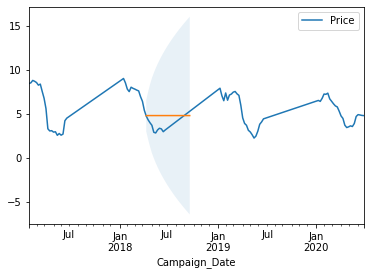

In [17]:
lower = prediction.conf_int()['lower Price']
upper = prediction.conf_int()['upper Price']
blue.truncate(before='2017').plot()
prediction.predicted_mean.plot()
plt.fill_between(lower.index,lower,upper, alpha=0.1)
plt.show()

In [18]:
model.fittedvalues

Campaign_Date
2016-01-04/2016-01-10    0.000000
2016-01-11/2016-01-17    9.394891
2016-01-18/2016-01-24    8.678687
2016-01-25/2016-01-31    6.214798
2016-02-01/2016-02-07    4.981455
                           ...   
2020-05-25/2020-05-31    3.903890
2020-06-01/2020-06-07    4.819961
2020-06-08/2020-06-14    5.038623
2020-06-15/2020-06-21    4.861136
2020-06-22/2020-06-28    4.742181
Freq: W-SUN, Length: 118, dtype: float64

### MSE, RMSE, MAE, MAPE

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Use against predictions

mse = mean_squared_error(model.fittedvalues, blue.Price)
rmse = np.sqrt(mean_squared_error(model.fittedvalues, blue.Price))
mae = mean_absolute_error(model.fittedvalues, blue.Price)
mape = np.mean(np.abs(model.fittedvalues-blue.Price)/blue.Price)

print(f'MSE {mse}, RMSE {rmse},*** \033[1mMAE {mae} ***\033[1m, MAPE {mape}')

MSE 1.5694765847748875, RMSE 1.2527875257899432,*** MAE 0.6051550013049392 ***, MAPE 0.10648283386946561


In [20]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
#https://stackoverflow.com/questions/34444607/how-to-ignore-statsmodels-maximum-likelihood-convergence-warning
best_aic = 999999
for p in range(3):
    for q in range(2):
        for d in range(2):
            try:
                model = SARIMAX(blue, order = (p, d, q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    print(p, d, q, model.aic, model.bic)
            except:
                pass

0 0 0 746.8338085215798 749.6044931460455
0 1 0 317.2321782772366 319.99435221203436
0 1 1 317.09388350910683 322.6182313787023
1 1 0 316.5208262676937 322.04517413728917
2 1 0 316.4100548221021 324.69657662649536


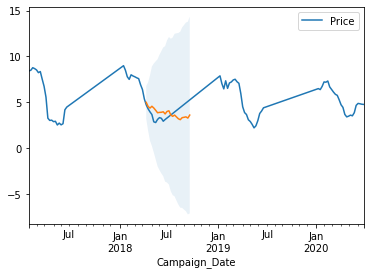

In [21]:
model = SARIMAX(blue, order = (6, 1, 2),seasonal_order=(1,1,2,12)).fit()
prediction = model.get_forecast(steps = 24)
lower = prediction.conf_int()['lower Price']
upper = prediction.conf_int()['upper Price']
blue.truncate(before='2017').plot()
prediction.predicted_mean.plot()
plt.fill_between(lower.index,lower,upper, alpha=0.1)
plt.show()

In [ ]:
### https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [24]:
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_absolute_error(test, predictions) #MAE is the metric selected as price fluctuation could be up or down
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MAE=%.3f' % (best_cfg, best_score))

In [23]:
# load dataset
blue = blue
# evaluate parameters
p_values = range(0, 6)
d_values = [0, 1, 2, 4]
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(blue.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=1.442
ARIMA(0, 0, 1) MSE=0.841
ARIMA(0, 0, 2) MSE=0.647
ARIMA(0, 1, 0) MSE=0.391
ARIMA(0, 1, 1) MSE=0.373
ARIMA(0, 1, 2) MSE=0.353
ARIMA(0, 2, 0) MSE=0.399
ARIMA(0, 2, 1) MSE=0.440
ARIMA(0, 2, 2) MSE=0.415
ARIMA(1, 0, 0) MSE=0.417
ARIMA(1, 0, 1) MSE=0.395
ARIMA(1, 0, 2) MSE=0.372
ARIMA(1, 1, 0) MSE=0.366
ARIMA(1, 1, 1) MSE=0.349
ARIMA(1, 1, 2) MSE=0.347
ARIMA(1, 2, 0) MSE=0.413
ARIMA(1, 2, 1) MSE=0.405
ARIMA(2, 0, 0) MSE=0.385
ARIMA(2, 1, 0) MSE=0.348
ARIMA(2, 1, 1) MSE=0.347
ARIMA(2, 1, 2) MSE=0.351
ARIMA(2, 2, 0) MSE=0.398
ARIMA(2, 2, 1) MSE=0.384
ARIMA(3, 0, 0) MSE=0.357
ARIMA(3, 1, 0) MSE=0.346
ARIMA(3, 1, 1) MSE=0.329
ARIMA(3, 1, 2) MSE=0.309
ARIMA(3, 2, 0) MSE=0.404
ARIMA(3, 2, 1) MSE=0.382
ARIMA(4, 0, 0) MSE=0.353
ARIMA(4, 1, 0) MSE=0.345
ARIMA(4, 1, 1) MSE=0.350
ARIMA(4, 1, 2) MSE=0.376
ARIMA(4, 2, 0) MSE=0.405
ARIMA(4, 2, 1) MSE=0.389
ARIMA(4, 2, 2) MSE=0.379
ARIMA(5, 0, 0) MSE=0.351
ARIMA(5, 1, 0) MSE=0.344
ARIMA(5, 1, 1) MSE=0.343
ARIMA(5, 1, 2) MSE=0.331


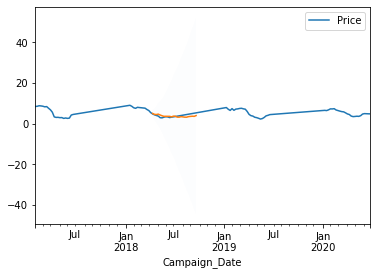

In [26]:
model = SARIMAX(blue, order = (5, 2, 2),seasonal_order=(1,1,2,12)).fit()
prediction = model.get_forecast(steps = 24)
lower = prediction.conf_int()['lower Price']
upper = prediction.conf_int()['upper Price']
blue.truncate(before='2017').plot()
prediction.predicted_mean.plot()
plt.fill_between(lower.index,lower,upper, alpha=0.01)
plt.show()

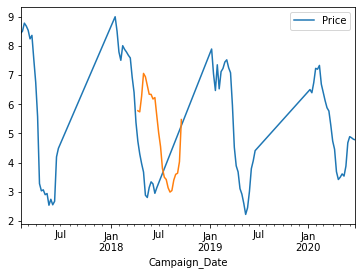

In [70]:
model = SARIMAX(blue, order = (5, 2, 2),seasonal_order=(1,1,2,24)).fit()
prediction = model.get_forecast(steps = 24)
#lower = prediction.conf_int()['lower Price']
#upper = prediction.conf_int()['upper Price']
blue.truncate(before='2017').plot()
prediction.predicted_mean.plot()
#plt.fill_between(lower.index,lower,upper, alpha=0.4)
plt.show()

In [71]:
prediction.predicted_mean.index

PeriodIndex(['2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03',
             '2018-06-04/2018-06-10', '2018-06-11/2018-06-17',
             '2018-06-18/2018-06-24', '2018-06-25/2018-07-01',
             '2018-07-02/2018-07-08', '2018-07-09/2018-07-15',
             '2018-07-16/2018-07-22', '2018-07-23/2018-07-29',
             '2018-07-30/2018-08-05', '2018-08-06/2018-08-12',
             '2018-08-13/2018-08-19', '2018-08-20/2018-08-26',
             '2018-08-27/2018-09-02', '2018-09-03/2018-09-09',
             '2018-09-10/2018-09-16', '2018-09-17/2018-09-23'],
            dtype='period[W-SUN]', freq='W-SUN')

In [72]:
blue[blue.index.year==2018].index

PeriodIndex(['2018-01-15/2018-01-21', '2018-01-22/2018-01-28',
             '2018-01-29/2018-02-04', '2018-02-05/2018-02-11',
             '2018-02-12/2018-02-18', '2018-02-19/2018-02-25',
             '2018-02-26/2018-03-04', '2018-03-05/2018-03-11',
             '2018-03-12/2018-03-18', '2018-03-19/2018-03-25',
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03',
             '2018-06-04/2018-06-10', '2018-06-11/2018-06-17',
             '2018-06-18/2018-06-24'],
            dtype='period[W-SUN]', name='Campaign_Date', freq='W-SUN')

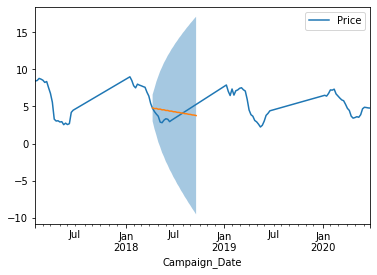

In [74]:
model = SARIMAX(blue, order = (5, 2, 2)).fit()
prediction = model.get_forecast(steps = 24)
lower = prediction.conf_int()['lower Price']
upper = prediction.conf_int()['upper Price']
fig, ax = plt.subplots()
blue.truncate(before = "2017").plot(ax = ax)
prediction.predicted_mean.plot(ax = ax)
ax.fill_between(lower.index, lower, upper, alpha = 0.4)
plt.show()

In [75]:
prediction.predicted_mean.index

PeriodIndex(['2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03',
             '2018-06-04/2018-06-10', '2018-06-11/2018-06-17',
             '2018-06-18/2018-06-24', '2018-06-25/2018-07-01',
             '2018-07-02/2018-07-08', '2018-07-09/2018-07-15',
             '2018-07-16/2018-07-22', '2018-07-23/2018-07-29',
             '2018-07-30/2018-08-05', '2018-08-06/2018-08-12',
             '2018-08-13/2018-08-19', '2018-08-20/2018-08-26',
             '2018-08-27/2018-09-02', '2018-09-03/2018-09-09',
             '2018-09-10/2018-09-16', '2018-09-17/2018-09-23'],
            dtype='period[W-SUN]', freq='W-SUN')